In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import scipy.stats as stats
import netron

In [2]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [3]:
# path = untar_data(URLs.CIFAR_100)
path = Path('data')

In [6]:
get_transforms??

Signature:
get_transforms(
    do_flip: bool = True,
    flip_vert: bool = False,
    max_rotate: float = 10.0,
    max_zoom: float = 1.1,
    max_lighting: float = 0.2,
    max_warp: float = 0.2,
    p_affine: float = 0.75,
    p_lighting: float = 0.75,
    xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None,
) -> Collection[fastai.vision.image.Transform]
Source:   
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rot

In [13]:
data = (
    (
        ImageList.from_folder(path, convert_mode='L')
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(do_flip=False, max_zoom=0.0, max_lighting=.2), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

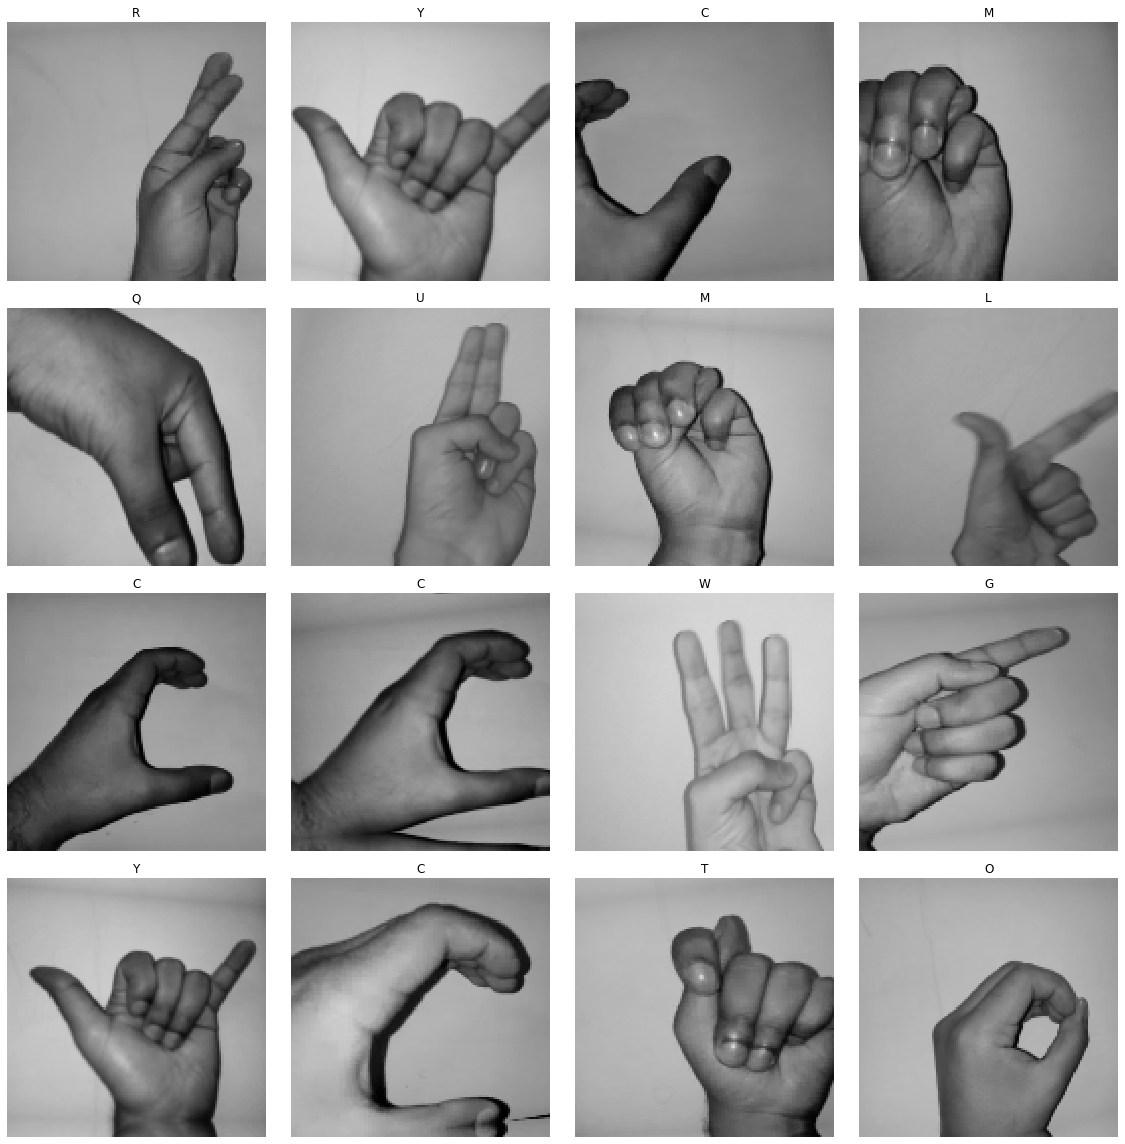

In [14]:
data.show_batch(4)

In [15]:
data.c

24

In [16]:
data

ImageDataBunch;

Train: LabelList (3978 items)
x: ImageList
Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128)
y: CategoryList
A,A,A,A,A
Path: data;

Valid: LabelList (994 items)
x: ImageList
Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128),Image (1, 128, 128)
y: CategoryList
K,T,A,D,X
Path: data;

Test: None

# LeNet

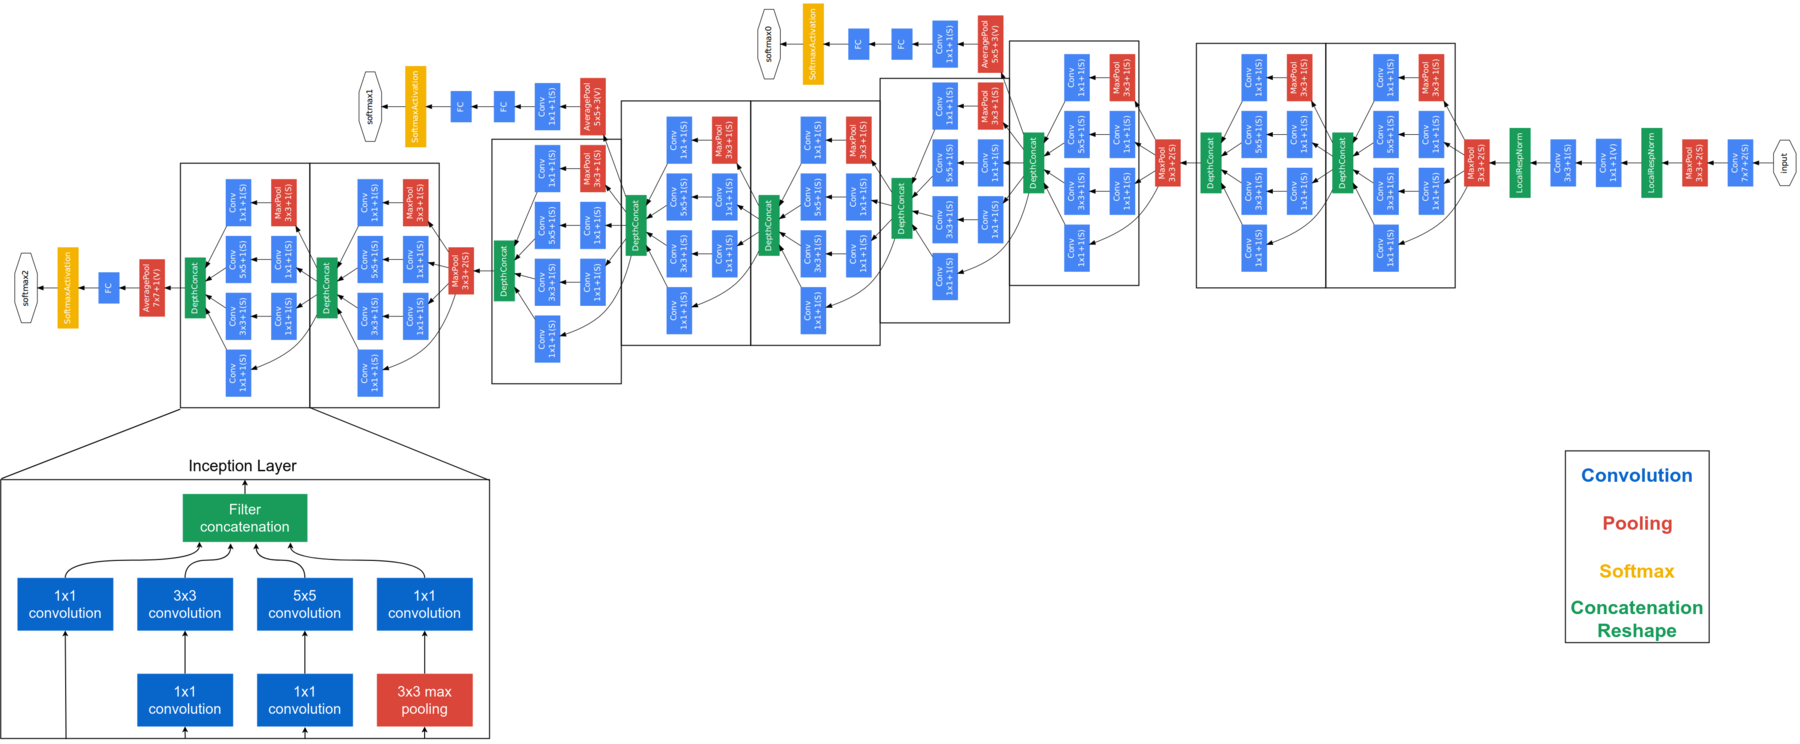

In [23]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [24]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes=24, conv_block=None):
        super(InceptionAux, self).__init__()
        conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4, 4))
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, 0.7)
        x = self.fc2(x)
        return x

In [25]:
class Inception(nn.Module):
    def __init__(
        self,
        in_channels,
        ch1x1,
        ch3x3red,
        ch3x3,
        ch5x5red,
        ch5x5,
        pool_proj,
        conv_block=None,
    ):
        super(Inception, self).__init__()
        conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

In [26]:
class Model(nn.Module):
    __constants__ = ["aux_logits", "transform_input"]

    def __init__(
        self,
        num_classes=24,
        aux_logits=True,
        transform_input=False,
        init_weights=True,
        blocks=None,
    ):
        super(Model, self).__init__()
        conv_block = BasicConv2d
        inception_block = Inception
        inception_aux_block = InceptionAux

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.maxpool = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)

        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)

        #                                  in_channels,ch1x1,ch3x3red,ch3x3,ch5x5red,ch5x5,pool_proj
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)
        self.aux1 = inception_aux_block(512, num_classes)
        self.aux2 = inception_aux_block(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        #         return x, aux2, aux1

        return x

In [27]:
learn = None
gc.collect()

20

In [28]:
learn = Learner(
    data,
    Model(),
    metrics=[accuracy, error_rate],
    opt_func=AdamW,
    callback_fns=ShowGraph,
).to_fp16()

In [29]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
MaxPool2d            [832, 4, 4]          0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [192, 32, 32]        110,592    True      
______________________________________________________________________
BatchNorm2d          [192, 32, 32]        384        True      
________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


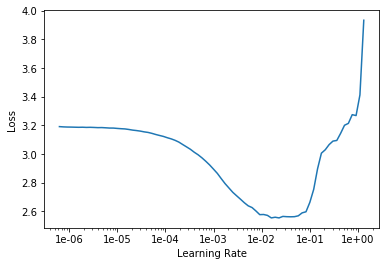

In [30]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.975901,3.394940,0.034205,0.965795,00:11
1,2.063363,1.001006,0.764588,0.235412,00:10
2,1.000485,0.396420,0.891348,0.108652,00:10
3,0.492685,0.202241,0.938632,0.061368,00:10
4,0.293425,0.148395,0.965795,0.034205,00:10
5,0.171375,0.062146,0.986922,0.013078,00:11
6,0.098613,0.018171,0.997988,0.002012,00:10
7,0.056014,0.008375,1.000000,0.000000,00:11
8,0.037054,0.006172,1.000000,0.000000,00:10
9,0.030262,0.006447,1.000000,0.000000,00:10


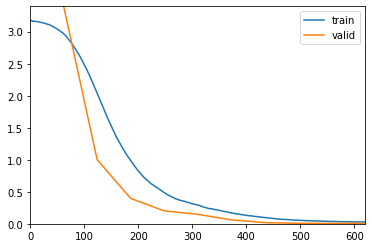

In [31]:
learn.fit_one_cycle(10, 1e-4)

In [32]:
learn.save('stage-1')

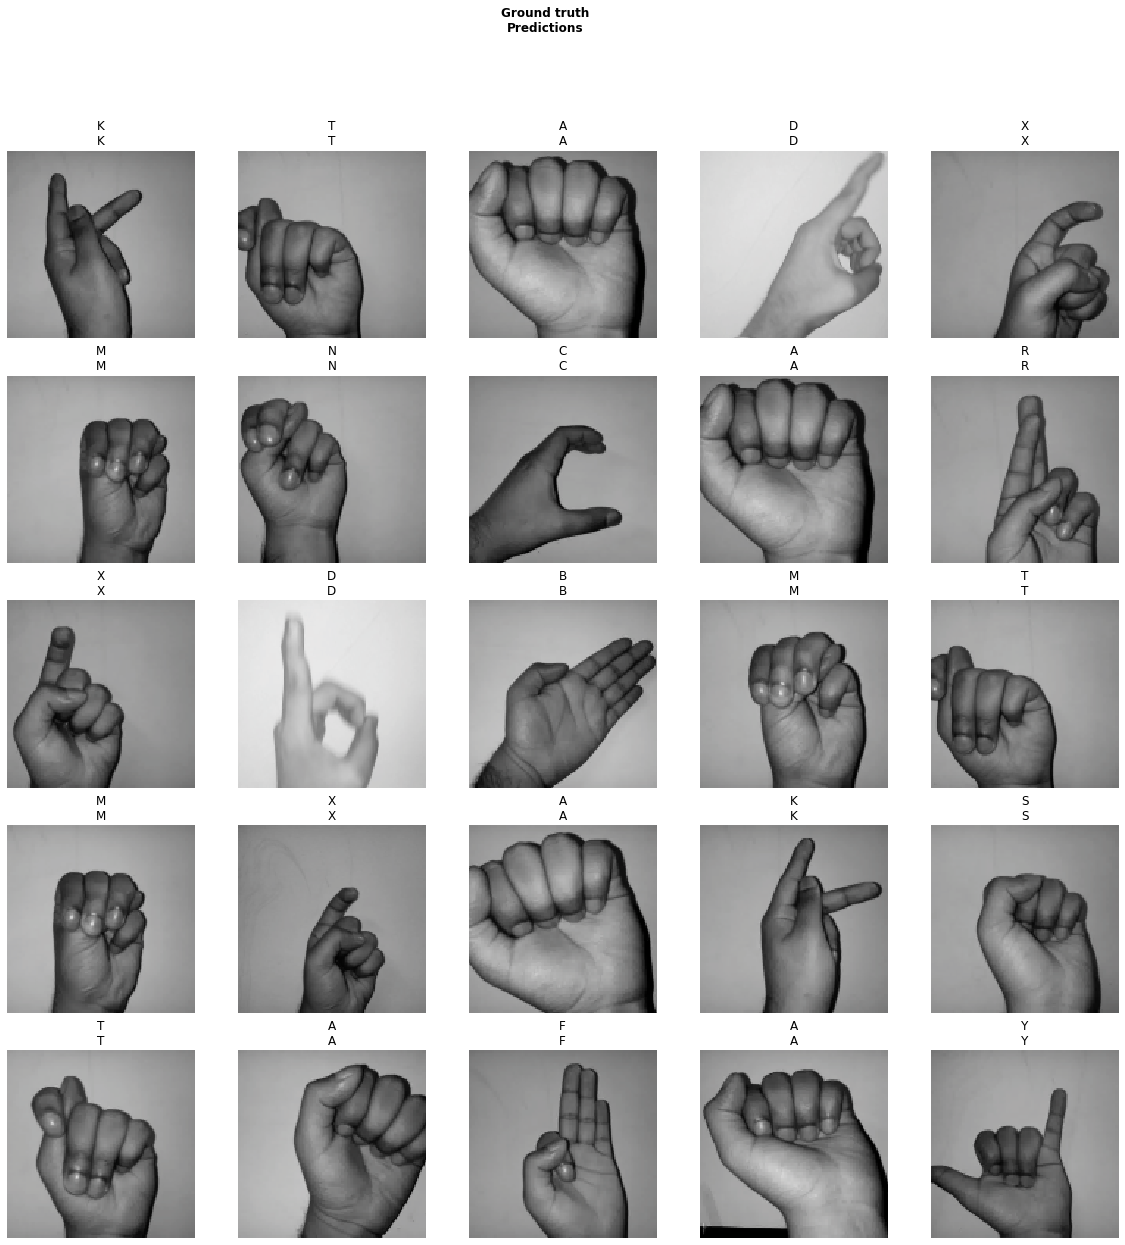

In [33]:
learn.show_results()

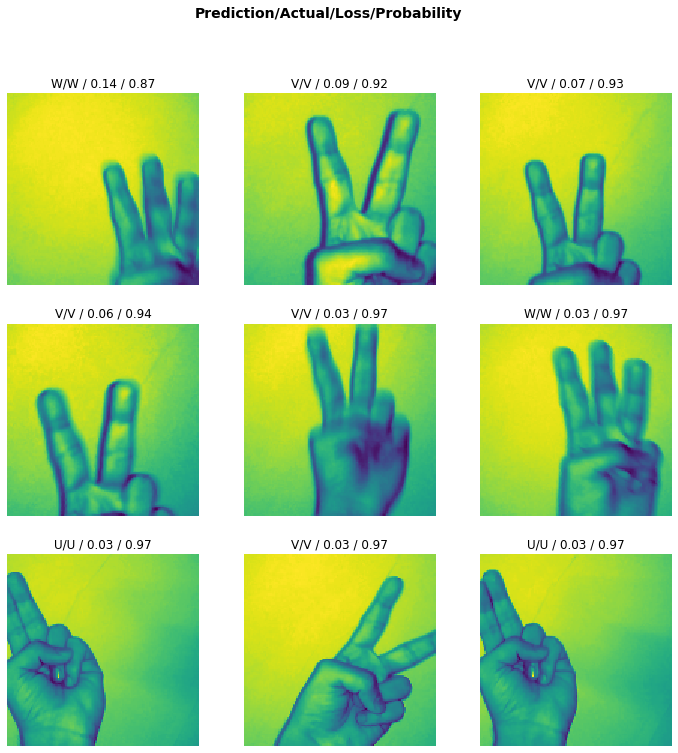

In [34]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9)

In [35]:
learn.predict(open_image('st.JPG','L'))

FileNotFoundError: [Errno 2] No such file or directory: 'st.JPG'

In [39]:
import torch.onnx
from torch.autograd import Variable
dummy_input = Variable(torch.randn(1, 3, 64, 64)).cuda().half()
torch.onnx.export(learn.model, dummy_input, "model.onnx")

In [44]:
netron.start("model.onnx")


Stopping http://localhost:8080
Serving 'model.onnx' at http://localhost:8080
